# Preparing Setup

## Declare instruments

In [2]:
import init # qcodes logs in the right location on the dataserver
import qcodes as qc
import numpy as np
import time
from time import sleep 
import matplotlib.pyplot as plt
import SpecialParameters 
from Librairie import Sweeper
import matplotlib.ticker as mt
import win32com.client
import zhinst
import io
from qcodes.dataset.measurements import Measurement 
from qcodes.dataset.plotting import plot_by_id
# from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import new_experiment
from qcodes.instrument.parameter import ManualParameter
from qcodes.utils.validators import Numbers
# from qcodes.dataset.database import initialise_or_create_database_at
from qcodes import Station, load_or_create_experiment,initialise_database, Measurement, Instrument,initialise_or_create_database_at, VisaInstrument, ManualParameter, MultiParameter, validators as vals
import qcodes_gre
# from qcodes_gre.measurements import qcodes_gui
from qcodes_gre.measurements import time_trace_uhf
from qcodes_gre.measurements.time_trace_uhf import DAMTrig
from qcodes_gre.measurements.time_trace_uhf import DAM
from qcodes.instrument_drivers.american_magnetics import AMI430 as AMI430_driver 
from tqdm.notebook import tqdm, trange
import broadbean as bb
from broadbean.plotting import plotter
import os 
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')
from scipy.ndimage import gaussian_filter1d
import re

from qcodes import validators as vals
# import importlib 
# importlib.reload(Librairie)

In [3]:
%matplotlib notebook

### Declare the station

In [4]:
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#$$$$$$$$$$$$$$$$$$$$$$$  Initialisation INST and create station $$$$$$$$$$$$$$$$$$$$$$$$$$
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
station=qc.Station()

### UHF

In [5]:
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#$$$$$$$$$$  UHF (Freqlocker)  $$$$$$$$$$$
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

from qcodes.instrument_drivers.ZI.ZIUHFLI import ZIUHFLI
uhfRef = 'dev2368'
ziUhf = ZIUHFLI('ZIUHFLI', uhfRef)
station.add_component(ziUhf)

Discovered device `dev2368`: UHFLI with options MF, MOD, AWG.
Creating an API session for device `dev2368` on `127.0.0.1`, `8004` with apilevel `5`.


'ZIUHFLI'

In [6]:
# station.close_and_remove_instrument(ziUhf)

In [7]:
#ziUhf._all_instruments.pop('ZIUHFLI')

In [8]:
from math import pi 

ph1 = ziUhf.demod1_phi
ph2 = ziUhf.demod2_phi
ph_g4=qc.ScaledParameter(ziUhf.demod2_phi, gain=2*pi/360*1000, name='Phi_g4', label='Phase Gate 4', unit='mrad')
ph3 = ziUhf.demod3_phi
ph_s=qc.ScaledParameter(ziUhf.demod3_phi, gain=2*pi/360*1000, name='Ph_s', label='Phase Source', unit='mrad')
ph4 = ziUhf.demod4_phi
ph5 = ziUhf.demod2_phi
ph5=qc.ScaledParameter(ziUhf.demod5_phi, gain=2*pi/360*1000, name='Phi5', label='Phase5', unit='mrad')
ph7 = ziUhf.demod7_phi
ph_d=qc.ScaledParameter(ziUhf.demod7_phi, gain=2*pi/360*1000, name='Phi_d', label='Phase Drain', unit='mrad')


In [9]:
DAM7 = DAM(ziUhf,7)
DAM_trig = DAMTrig(ziUhf,7)

### Dac Itest

In [10]:
# import importlib 
# importlib.reload(Itest)

In [1286]:
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#$$$$$$$$$$  DAC (Volt power)  $$$$$$$$$$$
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

# import qcodes.instrument_drivers.Bilt.iTest as iTest
import iTest as iTest

iTest_address = "TCPIP0::192.168.150.149::5025::SOCKET"
# iTest_address = "ASRL4::INSTR"
dac = iTest.ITest('DAC4', iTest_address)

#dac = iTest.ITest('DAC', iTest_address,num_chans=16)
#iTest_address = "TCPIP0::192.168.150.102::5025::SOCKET"
station.add_component(dac)

#permet de set a 9h le temps de non utilisation du dac. Impossible de faire plus long
#So le temps est trop court il est possible de lancer un autre kernet et de demander toutes les 8h un dac.IDN() pour empecher
#que le dac s'éteigne
dac.write('syst:eth:idl 32767')


Connected to: 2142 "ITEST BE2142B/12V 15mA DC-SOURCE/SN04-018 LC1846 VL446\240" (serial:None, firmware:None) in 0.44s


[DAC4(ITest)] Snapshot: Could not update parameter: start
[DAC4(ITest)] Snapshot: Could not update parameter: stop


In [1287]:
Vg1 = qc.ScaledParameter(dac.dac1, gain=1000, name='G1', label='VG1', unit='mV')
Vg2 = qc.ScaledParameter(dac.dac2, gain=1000/6.21, name='G2', label='VG2', unit='mV')
Vg2_fine = qc.ScaledParameter(dac.dac6, gain=1000/121.76, name='G2f', label='VG2_f', unit='mV')
Vg3 = qc.ScaledParameter(dac.dac3, gain=1000/6.24, name='G3', label='VG3', unit='mV')
Vg3_fine = qc.ScaledParameter(dac.dac7, gain=1000/122.18, name='G3f', label='VG3_f', unit='mV')
Vg4 = qc.ScaledParameter(dac.dac4, gain=1000, name='G4', label='VG4', unit='mV')

Vtg = qc.ScaledParameter(dac.dac5, gain=1000, name='GTop', label='VGtop', unit='mV')

Vds = qc.ScaledParameter(dac.dac8, gain=1000, name='VD', label='VDS', unit='mV')
# Vgrien = qc.ScaledParameter(dac.dac9, gain=1, name='Grien', label='VGrien', unit='mV')


In [44]:
# dac.set_dacs_zero()

ERROR: turn on the dac 15


In [1547]:
# awg._all_instruments.pop('DAC4')

<weakref at 0x0000015EB39BD9F8; to 'ITest' at 0x0000015EB39B2748>

In [1285]:
station.close_and_remove_instrument(dac)

### AWG

In [11]:
# station.close_and_remove_instrument(awg)

In [44]:
# importlib.reload(AWG5208_piot)
import AWG5208_piot
# importlib.reload(AWG70000A_piot)
import AWG70000A_piot

awg = AWG5208_piot.AWG5208('awg', 'TCPIP0::192.168.150.77::inst0::INSTR')
station.add_component(awg)
awg.clock_source('Internal, 10 MHZ ref.')
awg.ch1.marker2_high(1.5)

Connected to: TEKTRONIX AWG5208 (serial:B030535, firmware:FV:6.6.0131.0) in 0.06s


In [1724]:
# awg.jump_elem_in_seq(2)

In [899]:
# # import and initialise the driver and ensure that the sample
# # rate and channel voltage is correct

# # from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208
# awg = AWG5208('awg', 'TCPIP0::192.168.150.77::inst0::INSTR')
# station.add_component(awg)

Connected to: TEKTRONIX AWG5208 (serial:B030535, firmware:FV:6.3.0084.0) in 0.50s


'awg'

In [39]:
station.close_and_remove_instrument(awg)

NameError: name 'awg' is not defined

In [38]:
awg._all_instruments.pop('awg')

NameError: name 'awg' is not defined

In [15]:
awg.clearWaveformList()
awg.clearSequenceList()

### µ-wave source Agilent

In [17]:
import importlib 
importlib.reload(Agilent_E8527D_Lateqs)

NameError: name 'Agilent_E8527D_Lateqs' is not defined

In [1]:
# from Agilent_E8527D_Lateqs import Agilent_E8527D as Agi
import Agilent_E8527D_Lateqs 
Agilent_adress = 'TCPIP0::192.168.150.5::inst0::INSTR'
Singen=Agilent_E8527D_Lateqs.Agilent_E8527D('Sinus_Generator',Agilent_adress)
station.add_component(Singen)

In [1647]:
# station.close_and_remove_instrument('Sinus_Generator')

In [1644]:
Singen._all_instruments.pop('Sinus_Generator')

<weakref at 0x000001EBAB8DEB38; to 'Agilent_E8527D' at 0x000001EBE0E6F408>

In [1403]:
Singen.frequency(10e9)

In [140]:
Singen.power(-25)

In [1528]:
Singen.off()

In [1529]:
Singen.status()

'Off'

### Mega source Rhode Schwartz au prix d'une baraque avec piscine ... Môssieu!

In [15]:
import SMW200A

In [16]:
RS_adress = 'TCPIP0::192.168.150.6::inst0::INSTR'
Singen=SMW200A.RohdeSchwarz_SMW200A('Vector_Sinus_Generator',RS_adress)
station.add_component(Singen)

Connected to: Rohde&Schwarz SMW200A (serial:1412.0000K02/107172, firmware:04.60.092.24 SP1) in 0.03s


[Vector_Sinus_Generator(RohdeSchwarz_SMW200A)] Snapshot: Could not update parameter: LO_source
[Vector_Sinus_Generator(RohdeSchwarz_SMW200A)] Snapshot: Could not update parameter: ref_LO_out
[Vector_Sinus_Generator(RohdeSchwarz_SMW200A)] Snapshot: Could not update parameter: ref_osc_output_freq


'Vector_Sinus_Generator'

In [88]:
# station.close_and_remove_instrument('Vector_Sinus_Generator')

In [505]:
# Singen._all_instruments.pop('Vector_Sinus_Generator')

<weakref at 0x000001D44467AB38; to 'RohdeSchwarz_SMW200A' at 0x000001D4374AB108>

### Magnet 

In [17]:
from qcodes.instrument_drivers.american_magnetics import AMI430 as AMI430_driver 

In [18]:
z_magnet = AMI430_driver.AMI430('z_magnet', "192.168.150.222", 7180)
station.add_component(z_magnet)

Connected to: AMERICAN MAGNETICS INC. 430 (serial:180053, firmware:3.07) in 1.13s


'z_magnet'

In [19]:
z_magnet.field()

0.9129659

In [20]:
# awg._all_instruments.pop('z_magnet')
# station.close_and_remove_instrument('z_magnet')

In [21]:
x_magnet = AMI430_driver.AMI430('x_magnet', "192.168.150.221", 7180)
station.add_component(x_magnet)

Connected to: AMERICAN MAGNETICS INC. 430 (serial:180049, firmware:3.07) in 1.07s


'x_magnet'

In [22]:
# station.close_and_remove_instrument('x_magnet')
# x_magnet._all_instruments.pop('x_magnet')

In [23]:
x_magnet.field()

-0.0001968

In [30]:
print(qc.__version__)

0+untagged.8181.gbb04912.dirty


## Create Database 


In [24]:
initialise_or_create_database_at('../data/2021_04_02.db')
qc.config.core.db_location
sample_name = '4G23_1'
exp_name = 'Test_RT'
exp = qc.new_experiment(exp_name, sample_name)

# Most of required functions

This is the place to store the functions, to be executed if the kernel crashes.

A function can temporarilly be defined somewhere else but once "stable" it MUST end up there.

Then if we have to apply modifications to some of these functions we directly modify them here.

In [25]:
def multiplot_by_id (ids,ax=None) :
    for i in ids :
        b=str(i)
        ax, _ = plot_by_id(i,ax,label=b)
        plt.legend
    return ax    

## UHF (DAQ, Phaze Zero...)

In [26]:
def N_time_traces_init2(N = 20, T = 250e-6):
    '''
    Record N time traces of duration T
    Returns a matrix with all time traces and a vector with its average over the N realizations
    '''
    t, Matrix = DAM_trig.get_data_pulseseq(T,N)
    Av = np.mean(Matrix,1)
    Matrix=np.transpose(Matrix)
    return Matrix,Av,t

In [27]:
### Phase 0 function juste pour la premiere voie de l'UHF
def phaseZero():
    tc = ziUhf.daq.getDouble('/'+uhfRef+'/demods/4/timeconstant')
    time.sleep(5*tc)
    meanphase = 0
    numAverages = 10
    for i in range(numAverages):
        meanphase += np.rad2deg(phase.get())/numAverages
        
    ziUhf.daq.setDouble('/'+uhfRef+'/demods/4/phaseshift', ziUhf.daq.getDouble('/'+uhfRef+'/demods/4/phaseshift') + meanphase)
    time.sleep(5*tc)
    
def phasezero_ph1():
    tc = ziUhf.daq.getDouble('/dev2368/demods/0/timeconstant')
    time.sleep(5*tc)
    meanphase = 0
    numAverages = 10
    for i in range(numAverages):
        meanphase += ph1()
        
        
    meanphase=meanphase/numAverages
    
    ziUhf.daq.setDouble('/dev2368/demods/0/phaseshift', ziUhf.daq.getDouble('/dev2368/demods/0/phaseshift') + meanphase[0])
    time.sleep(0.1)
    
def phasezero_ph3():
    tc = ziUhf.daq.getDouble('/dev2368/demods/2/timeconstant')
    time.sleep(5*tc)
    meanphase = 0
    numAverages = 10
    for i in range(numAverages):
        meanphase += ph3()
        
    meanphase=meanphase/numAverages
    
    ziUhf.daq.setDouble('/dev2368/demods/2/phaseshift', ziUhf.daq.getDouble('/dev2368/demods/2/phaseshift') + meanphase[0])
    time.sleep(0.1)    

def phasezero_ph2():
    tc = ziUhf.daq.getDouble('/dev2368/demods/1/timeconstant')
    time.sleep(5*tc)
    meanphase = 0
    numAverages = 10
    for i in range(numAverages):
        meanphase += ph2()                
        
    meanphase=meanphase/numAverages
    
    ziUhf.daq.setDouble('/dev2368/demods/1/phaseshift', ziUhf.daq.getDouble('/dev2368/demods/1/phaseshift') + meanphase[0])
    time.sleep(0.1)   

def phasezero_ph7():
    tc = ziUhf.daq.getDouble('/dev2368/demods/6/timeconstant')
    time.sleep(5*tc)
    meanphase = 0
    numAverages = 10
    for i in range(numAverages):
        meanphase += ph7()
        
        
    meanphase=meanphase/numAverages
    
    ziUhf.daq.setDouble('/dev2368/demods/6/phaseshift', ziUhf.daq.getDouble('/dev2368/demods/6/phaseshift') + meanphase[0])
    time.sleep(0.1)        

In [28]:
## Fonction servant a donner la puissance et le voltage appliqué en bas de la ligne G2, le paramettre att peut être changé e n
## cas d'utilisation d'une autre ligne

def volt_on_g2(amp,att=-46) : 
    power=amp**2/50*1000
    dbm=10*np.log10(power)
    dbm2=dbm+att
    power=10**(dbm2/10)/1000
    print('power(w) = ' ,power)
    amp2=np.sqrt(50*power)
    print('voltage (microV) [50ohm line] = ' , amp2*1e6)
    return amp2, power

## Blops IQ, tunnel rates, find working points etc...

In [29]:
## Attention fonction très sale et pas adaptable aux autres setup. Absolument revenir dessus pour plus de controle tel
## que probablement l'initialisation du DAM en fonction du démod etc !!! Très mauvais tel quel

def blopIQ(DAM,tc,timetot,demod,path,G2f,G3f,title='I/Q measure') :
    ziUhf.daq.setDouble('/'+uhfRef+'/demods/{}/timeconstant'.format(demod-1),tc)
    ziUhf.daq.setDouble('/'+uhfRef+'/demods/{}/rate'.format(demod-1),1/tc)
    
    pathtxt=path+'.txt'

    DAM.get_data_txt(timetot,pathtxt,'x','y',affichage=False)

    data=np.loadtxt(pathtxt)
    file=open(pathtxt)
    read=file.read()
    file.close()
    read=read[1:read.find('\n')]
    parameters=read.split(';')

    for i,stringi in enumerate(parameters) :
        if parameters[i].find('x')>=0 :
            xvalues=data[:,i]
            xlabel=stringi
        if parameters[i].find('y')>=0 :
            yvalues=data[:,i]
            ylabel=stringi

    fig = plt.figure(figsize=(10, 10))
    grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)
    
    size = 14
    
    main_ax = fig.add_subplot(grid[:-1, 1:])
    main_ax.set_title('I/Q measure',size=size)
    main_ax.ticklabel_format(axis='both',style='sci',scilimits=[-6,-6])
#     main_ax.set_aspect('equal')

    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    y_hist.ticklabel_format(axis='y',style='sci',scilimits=[-6,-6])
    y_hist.set_ylabel(ylabel,fontsize=size)

    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)
    x_hist.ticklabel_format(axis='x',style='sci',scilimits=[-6,-6])
    x_hist.set_xlabel(xlabel,fontsize=size)

    color='darkorange'
    alpha=0.8
    # scatter points on the main axes
    main_ax.plot(xvalues, yvalues, 'ok', markersize=3, alpha=0.2,color=color)
    main_ax.set_aspect('equal')

    # histogram on the attached axes
    x_hist.hist(xvalues, 200,
                orientation='vertical', color=color,alpha=alpha)
    x_hist.invert_yaxis()

    y_hist.hist(yvalues, 200,
                orientation='horizontal', color=color,alpha=alpha)
    y_hist.invert_xaxis()
    
    main_ax.tick_params(labelsize=14)
    x_hist.tick_params(labelsize=14)
    y_hist.tick_params(labelsize=14)

    fig.tight_layout()

    
    fig.savefig(path,dpi=600)
    
    path = f'..\exploration/1-all_Bubbles'
    
    try : 
        os.mkdir(path)
    except :
        print('Dossier existant')

    fig.savefig(path+f'\g2=%s_g3=%s '%(str(int(float(G2f))),str(int(float(G3f))))+title,dpi=600)

path=[f'..\exploration\Saving_process\g2=-638.475_g3=-949.55/IQ_on_signal.txt',f'..\exploration\Saving_process\g2=-638.475_g3=-949.55/IQ_out_of_signal.txt']

def draw_multiple_bbl(path,path_register,G2f,G3f) :

    fig = plt.figure(figsize=(10, 10))
    grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)
    size = 14
    main_ax = fig.add_subplot(grid[:-1, 1:])
    main_ax.set_title('I/Q measure',size=size)
    main_ax.ticklabel_format(axis='both',style='sci',scilimits=[-6,-6])

    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    y_hist.ticklabel_format(axis='y',style='sci',scilimits=[-6,-6])

    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)
    x_hist.ticklabel_format(axis='x',style='sci',scilimits=[-6,-6])
    
    color_all=['darkorange','tomato','blue','green','black']
    
    for j,pathh in enumerate(path) :
        data=np.loadtxt(pathh)
        file=open(pathh)
        read=file.read()
        file.close()
        read=read[1:read.find('\n')]
        parameters=read.split(';')

        for i,stringi in enumerate(parameters) :
            if parameters[i].find('x')>=0 :
                xvalues=data[:,i]
                xlabel=stringi
            if parameters[i].find('y')>=0 :
                yvalues=data[:,i]
                ylabel=stringi

        color=color_all[j]
        alpha=0.8
        # scatter points on the main axes
        main_ax.plot(xvalues, yvalues, 'ok', markersize=3, alpha=0.2,color=color)

        # histogram on the attached axes
        x_hist.hist(xvalues, 200,
                    orientation='vertical', color=color,alpha=alpha)
        x_hist.invert_yaxis()

        y_hist.hist(yvalues, 200,
                    orientation='horizontal', color=color,alpha=alpha)
        y_hist.invert_xaxis()
        
    y_hist.set_ylabel(ylabel,fontsize=size)
    x_hist.set_xlabel(xlabel,fontsize=size)
    main_ax.tick_params(labelsize=14)
    x_hist.tick_params(labelsize=14)
    y_hist.tick_params(labelsize=14)
    
    title=f'IQ_double_bbl'
    
    fig.savefig(path_register+f'/'+title,dpi=600)
    
    patth = f'..\exploration/1-all_Bubbles'

    fig.savefig(patth+f'\g2=%s_g3=%s '%(str(int(float(G2f))),str(int(float(G3f))))+title,dpi=600)

    fig.tight_layout()
    
def register_time_trace(DAM,start,stop,num_point,tc,total_time,demod,path,coeff_dir) :
    
    ziUhf.daq.setDouble('/'+uhfRef+'/demods/{}/timeconstant'.format(demod-1),tc)
    ziUhf.daq.setDouble('/'+uhfRef+'/demods/{}/rate'.format(demod-1),1/tc)
    
    path_ex=np.array([])
    
    try : 
        os.mkdir(path)
    except :
        print('Dossier existant')

    profondeur=np.linspace(start,stop,num_point)

#     for i,j in enumerate(profondeur) :
    for i in trange(len(profondeur)):
        j = profondeur[i]
        path_register=path+f'/vg2f=%smV_vg3f=%smV'%(round(j,3),round(coeff_dir*j,3))
        if i==0 :
            Vg2_fine(j)
            Vg3_fine(coeff_dir*j) 
            DAM.get_data_bin(total_time,path_register)
            
        else :     
            Vg2_fine(j)
            Vg3_fine(coeff_dir*j) 
            DAM.get_data_bin(total_time,path_register,header=False,affichage=False)
            
        path_ex=np.append(path_ex,path_register)  
               
    text_file = open(path+f'\paths.txt', "w")
    for i in path_ex : 
        text_file.write(i + f';')
    text_file.close()   
        
    return(path_ex)    

def precise_working_point(epsilon,phase,path) :
        
    smooth_phase= gaussian_filter1d(phase, 15)   
    phase_deriv=np.diff(smooth_phase)

#     mi=np.min(phase_deriv)
#     ma=np.max(phase_deriv)

#     if abs(mi)>abs(ma) :
#         sol=mi
#     else :
#         sol=ma

#     pos=np.where(phase_deriv==sol) 

    mi=np.min( smooth_phase )
    ma=np.max( smooth_phase )    

    sol=(mi+ma)/2
    
    if sol>0 : 
        pos=np.where((smooth_phase>0.3*sol) & (smooth_phase<1.3*sol))[0]
    else :    
            pos=np.where((smooth_phase<0.3*sol) & (smooth_phase>1.3*sol))[0]
    
    pos_fin=pos[len(pos)//2]
    

#     if len(pos)%2==0 : 
#         pos=pos[len(pos)/2]
#     else :
#         pos=pos[len(pos)/2 + 1/2]
    
    
    plt.figure()
    plt.plot(epsilon,phase)
    plt.plot(epsilon,smooth_phase)
    plt.scatter(epsilon[pos_fin],phase[pos_fin],color=[1,0,1],marker='x',s=200)
    plt.title('Working point')
    plt.xlabel('Vg2_fine (mV)')
    plt.ylabel('Phase (mrad)')
    
    title=f'Working_point'    
    plt.savefig(path+f'/'+title,dpi=600)

    return epsilon[pos_fin],phase[pos_fin]
        
def Occupations_and_times(array,Threshold, Do_plot = False):
#     import time
    '''
    #### Function that takes as input an array, corresponding to a phase versus time trace ###

    array: must be an array of the time trace. First column = Time, Second column = phase 
    Threshold: value of the signal chosen to separate the two detected states
    
    returns the normlaized probablities of begin up or down, as well as the average times spent up and down in seconds

    '''
   
    T = array[:,0]
    PH = array[:,1]
    tstep = T[1]-T[0]
    Ttot = len(T)*tstep
    
    if Do_plot == True:
        f = plt.figure()
        f = plt.plot(T,PH)
    Ts_up = [0]
    Ts_down = [0]
#     t0 = time.time()
    j = 0
    for i,ph in enumerate(PH):
        if ph > Threshold:
            if i > 1 and PH[i-1] < Threshold:
                Ts_up.append(1)
                j = j+1
            elif i > 1 and PH[i-1] > Threshold:
                Ts_up[j] = Ts_up[j] + 1

    j = 0
    for i,ph in enumerate(PH):
        if ph < Threshold:
            if i > 1 and PH[i-1] < Threshold:
                Ts_down[j] = Ts_down[j] + 1  
            elif i > 1 and PH[i-1] > Threshold:
                Ts_down.append(1)
                j = j+1
    
    P_up = sum(Ts_up)/len(PH)
    P_down = sum(Ts_down)/len(PH)
    T_up = np.mean(Ts_up)*tstep    # time spent in the two different states
    T_down = np.mean(Ts_down)*tstep 
#     t1 = time.time()
#     print('Done in', t1-t0 , 's')
    return P_up,P_down,T_up,T_down

### Give the number of the triple point you want to analyse:

def analyse_time_traces(path,Threshold,G2f,G3f) :
    
    print(path)
    file = path+f'/time_traces/paths.txt'
    with open(file) as f:
        for line in f:
                paths = line.split(";")
#     Name = re.sub('../../exploration','',path)       
    Ps_up = []
    Ps_down = []
    Ts_up = []
    Ts_down = []
    for i in trange(len(paths)-1):
        path1 = paths[i]
        data = np.load(path1+'.npy')
        P_up,P_down,T_up,T_down = Occupations_and_times(data,Threshold, Do_plot = False)
        Ps_up.append(P_up)
        Ps_down.append(P_down)
        Ts_up.append(T_up)
        Ts_down.append(T_down)

    Vg = np.linspace(-0.1,0.1,len(Ps_up))    

    ## Plot the occupations up/down:
    fig,ax = plt.subplots()
    plt.plot(Vg,Ps_up)
    plt.plot(Vg,Ps_down)
    plt.xlabel('$Vg_2 fine$ (mV)',fontsize=18)
    plt.ylabel('$P_{in},P_{out}$',fontsize=18)
    ax.tick_params(labelsize=14)
    ax.set_title('Occupations up/down',size=18)
    fig.tight_layout()
    plt.savefig(path+f'/Occupation.png')

    ## Plot the tunnel rates:
    gamma_up = 1/np.array(Ts_up)
    gamma_down = 1/np.array(Ts_down)

    fig,ax = plt.subplots()
    plt.plot(Vg,gamma_up*1e-3)
    plt.plot(Vg,gamma_down*1e-3)
    plt.ylim(-0.01,40)
    plt.xlabel('$Vg_2 fine$ (mV)',fontsize=18)
    plt.ylabel('$\Gamma_{in},\Gamma_{out}$ (kHz)',fontsize=18)
    ax.tick_params(labelsize=14)
    ax.set_title('Rates up/down',size=18)
    fig.tight_layout()
    plt.savefig(path+f'/Rates.png')
    
    path_register = f'..\exploration/2-all_Rates'
    title=f'gamma_rates'
    
    try : 
        os.mkdir(path_register)
    except :
        print('Dossier existant')

    fig.savefig(path_register+f'\g2=%s_g3=%s '%(str(int(float(G2f))),str(int(float(G3f))))+title,dpi=600)



    ### recalulate a posteriori the optimal threshold looking at eps ~ 0
#     A = np.array(Ps_up)
#     ind = np.where((A > 0.2) & (A < 0.55))
#     print(ind[0][-1])
#     path = paths[int(ind[0][-1])]
#     data = np.load('../'+path+'.npy')
#     Threshold_after = Threshold_from_time_trace(data)
#     Hist_from_time_trace(data,Threshold_after)
#     plt.title('Threshold at $\epsilon = 0$: '+str(round(Threshold_after*100)/100)+'(used =' + str(Threshold) + ')',size=18)
#     plt.savefig(path+'Threshold_eps=0.png')

def save_by_id (id,G2f,G3f) :
    data=qc.load_by_id(id)

    db_name=data.path_to_db[data.path_to_db.find('data')+5:]

    Param=data.parameters
    Param=Param.split(',')

    VarX=data.get_parameters()[0].unit
    nameX=data.get_parameters()[0].name
    VarY=data.get_parameters()[1].unit
    nameY=data.get_parameters()[1].name
    Varmap=data.get_parameters()[2].unit
    namemap=data.get_parameters()[2].name


    X=np.unique(data.get_parameter_data()[Param[2]][Param[0]])
    Y=np.unique(data.get_parameter_data()[Param[2]][Param[1]])
    phase=np.array(data.get_parameter_data()[Param[2]][Param[2]])
    Map=phase.reshape(np.size(X),np.size(Y))
    Map=np.transpose(Map)

    fig,ax=plt.subplots()
    im=ax.pcolormesh(X,Y,Map)
    cb=fig.colorbar(im, ax=ax)
    cb.set_label(namemap+ ' (' + Varmap+')')
    ax.title.set_text('database {} \n data_id {} \n '.format(db_name,id))
    ax.set_xlabel(nameX+ ' (' + VarX+')')
    ax.set_ylabel(nameY+ ' (' + VarY+')')
    ax.set_xlim(np.min(X),np.max(X))
    ax.set_ylim(np.min(Y),np.max(Y))    
    fig.tight_layout()

    path = f'..\exploration/g2=%s_g3=%s'%(G2f,G3f)

    try : 
        os.mkdir(path)
    except :
        print('Dossier existant')

    fig.savefig(path+f'\interdot_image',dpi=600)
    
    path = f'..\exploration/0-all_interdot'
    
    try : 
        os.mkdir(path)
    except :
        print('Dossier existant')

    fig.savefig(path+f'\g2=%s_g3=%s'%(str(int(float(G2f))),str(int(float(G3f)))),dpi=600)


def find_working_point_by_id(data_id,G2f,G3f,Plot = True, savefig = True):
# Function aimed to find the point at which the interdot breaks, starting from the id a of a small plot centered on a G2 transition

    data = qc.load_by_id(data_id)
    VarX=data.get_parameters()[0].unit
    nameX=data.get_parameters()[0].name
    VarY=data.get_parameters()[1].unit
    nameY=data.get_parameters()[1].name
    Varmap=data.get_parameters()[2].unit
    namemap=data.get_parameters()[2].name

    data_list = data.get_parameter_data()
    P = data.parameters
    p = P.split(',')
    X = data_list[p[2]][p[0]]
    Y = data_list[p[2]][p[1]]
    x = (np.unique(X))
    y = np.unique(Y)

    Vg3 = x
    Vg2 = y
    #Z1(Vg2,Vg3)!!!

    z1 = data_list[p[2]][p[2]]
    Z1 = np.transpose(z1.reshape((np.size(np.unique(X)),np.size(np.unique(Y)))))
    
# find maximum along the dot-lead
    ind1 = np.argmax(Z1[0,:])
    V1 = Vg3[ind1]
    Vpk = np.zeros(len(Vg2))
    for i in range(len(Vg2)):
        ind1 = np.argmax(Z1[i,:])
        Vpk[i] = Vg3[ind1]
# fit this maximum with a linear approx, only from the upper part of the plot:

    Ncut = int(len(Vg2)*0.4)  # number of points to take from upper of the scan 
    a,b = np.polyfit(Vg2[-Ncut:],Vpk[-Ncut:], 1)                   #linear fit to extract alpha

    # Extract profile along line:
    profile = np.zeros(len(Vg2))
    Eps = np.zeros(len(Vg2))
    V3 = a*Vg2+b
    delta = abs(Vg3[1]-Vg3[0])
#     delta = 0.015

    for i,V in enumerate(Vg2):
        indVg3 = np.where( (Vg3 > V3[i] - delta) & (Vg3 < V3[i] + delta))
        ind = indVg3[0][0]
        profile[i] = Z1[i,ind]

    # Find Vg2 corresponding to the middle of the jump
    mi = np.max(profile)
    ma = np.min(profile)
    av = (mi+ma)/2
    arg = np.where((profile > av - 70) & (profile < av + 10))
    V2p = Vg2[arg[0][-1]]
    # Find the corresponding Vg3:
    V3p = a*V2p+b   

#     print(V2p,V3p)
    if Plot == True:
        fig,ax=plt.subplots()
        X,Y = np.meshgrid(x,y)
        f = plt.pcolor(X,Y,Z1)    # 2D plot  
        ax.set_xlabel(nameX+ ' (' + VarX+')')
        ax.set_ylabel(nameY+ ' (' + VarY+')')

        f = plt.plot(Vpk[-Ncut:],Vg2[-Ncut:],color=(0,0,1))     # Plot of the max
        f = plt.plot(a*Vg2+b,Vg2, '--',color = (1,0,0),linewidth = 0.5)     # Plot of the linear fit
        f = plt.scatter(V3p,V2p,color = (1,0,1),marker = 'x',s =150)
        db_name=data.path_to_db[data.path_to_db.find('data')+5:]
        ax.title.set_text('database {} \n data_id {} \n '.format(db_name,data_id))
        plt.tight_layout()
        if savefig == True:
                        
            
#             plt.savefig('../analysis/Triple_points/Vg2='+str(round(V3p*1000)/1000)+'Vg2='+str(round(V2p*1000)/1000)+'.png')
            
                        
            path = f'..\exploration\g2=%s_g3=%s'%(G2f,G3f)

            try : 
                os.mkdir(path)
            except :
                print('Dossier existant')
            Field = z_magnet.field()
            plt.savefig(path+f'/interdot_working_point_B='+str(round(Field,3))+'T.png',dpi=600)
      
#             plt.savefig(path+f'/interdot_working_point',dpi=600)
        
            path = f'..\exploration/0-all_interdot'

            try : 
                os.mkdir(path)
            except :
                print('Dossier existant')

            plt.savefig(path+f'\g2=%s_g3=%s_working_point'%(str(int(float(G2f))),str(int(float(G3f)))),dpi=600)

    # plot profile:    
    # f = plt.subplot(1,2,2)
    if Plot == True:
        f = plt.figure()
        f = plt.plot(Vg2,profile,color=(0,0,1))
        f = plt.vlines(V2p,mi,ma,color = (1,0,1),linestyles='dashed')
        plt.title('Slice along the transition')
        plt.xlabel('Vg2 (mV)')
        plt.ylabel('Phase (mrad)')
        plt.tight_layout()
        if savefig == True:
#             plt.savefig('../analysis/Triple_points/Vg2='+str(round(V3p*1000)/1000)+'Vg2='+str(round(V2p*1000)/1000)+'_profile.png')

            path = f'..\exploration\g2=%s_g3=%s'%(G2f,G3f)

            plt.savefig(path+f'\interdot_working_slice',dpi=600)

            path = f'..\exploration/0-all_interdot'

            plt.savefig(path+f'\g2=%s_g3=%s_working_slice'%(str(int(float(G2f))),str(int(float(G3f)))),dpi=600)            
            
    return V2p,V3p,a,b

def find_operand_point_by_id(data_id) :
    data=qc.load_by_id(92)

    Param=data.parameters
    Param=Param.split(',')

    VarX=data.get_parameters()[0].unit
    nameX=data.get_parameters()[0].name
    VarY=data.get_parameters()[1].unit
    nameY=data.get_parameters()[1].name
    Varmap=data.get_parameters()[2].unit
    namemap=data.get_parameters()[2].name

    X=np.unique(data.get_parameter_data()[Param[2]][Param[0]])
    Y=np.unique(data.get_parameter_data()[Param[2]][Param[1]])
    phase=np.array(data.get_parameter_data()[Param[2]][Param[2]])
    Map=phase.reshape(np.size(X),np.size(Y))
    Map=np.transpose(Map)
    
    Map_derive_hist=Map_derive.reshape(np.size(X)*(np.size(Y)-1),1)
    Nbins=200
    N, bins, patches = ax.hist(Map_derive_hist, edgecolor='white',bins=Nbins, linewidth=1)
    nmax=N.max()

    cond=nmax/2
    sig=np.where(cond<N)
    sigma=np.max(sig)-np.min(sig)

    n_sig=3
    Threshold=bins[np.argmax(N)+n_sig*sigma]     

    mask=masque(Map_derive,Threshold) 
    
    mask2=np.append(mask,np.nan*np.zeros(np.size(X)))
    mask2=mask2.reshape(np.size(Y),np.size(X))
    mask4=mask2

    for i in np.arange(np.shape(mask2)[0]) : 
        for j in np.arange(np.shape(mask2)[1]) :
            if mask2[i,j]==1 :
                mask4[i,j]=1
            else :
                mask4[i,j]=0
                
    ligne,colonne=np.where(mask4==1)
    
    valx=np.array([])
    valy=np.array([])
    vg3_array=np.array([])
    vg2_array=np.array([])
    
    for i in np.arange(np.size(ligne)-1):
        valx=np.append(valx,X[colonne[i]])
        valy=np.append(valy,Y[ligne[i]])
        if ligne[i+1]-ligne[i]>10 :
            vg3_array=np.append(vg3_array,(np.min(valx)+np.max(valx))/2)
            vg2_array=np.append(vg2_array,(np.min(valy)+np.max(valy))/2)
            valx=np.array([])
            valy=np.array([])
    
    vg3_array=np.append(vg3_array,(np.min(valx)+np.max(valx))/2)
    vg2_array=np.append(vg2_array,(np.min(valy)+np.max(valy))/2)

    return vg3_array,vg2_array

def find_working_point_by_id_inv(data_id,G2f,G3f,Plot = True, savefig = True):
# Function aimed to find the point at which the interdot breaks, starting from the id a of a small plot centered on a G2 transition

    data = qc.load_by_id(data_id)
    VarX=data.get_parameters()[0].unit
    nameX=data.get_parameters()[0].name
    VarY=data.get_parameters()[1].unit
    nameY=data.get_parameters()[1].name
    Varmap=data.get_parameters()[2].unit
    namemap=data.get_parameters()[2].name

    data_list = data.get_parameter_data()
    P = data.parameters
    p = P.split(',')
    X = data_list[p[2]][p[0]]
    Y = data_list[p[2]][p[1]]
    x = (np.unique(X))
    y = np.unique(Y)

    Vg3 = x
    Vg2 = y
    #Z1(Vg2,Vg3)!!!

    z1 = data_list[p[2]][p[2]]
    Z1 = np.transpose(z1.reshape((np.size(np.unique(X)),np.size(np.unique(Y)))))
    
# find maximum along the dot-lead
    ind1 = np.argmax(Z1[0,:])
    V1 = Vg3[ind1]
    Vpk = np.zeros(len(Vg2))
    for i in range(len(Vg2)):
        ind1 = np.argmin(Z1[i,:])
        Vpk[i] = Vg3[ind1]
# fit this maximum with a linear approx, only from the upper part of the plot:

    Ncut = int(len(Vg2)*0.4)  # number of points to take from upper of the scan 
    a,b = np.polyfit(Vg2[-Ncut:],Vpk[-Ncut:], 1)                   #linear fit to extract alpha

    # Extract profile along line:
    profile = np.zeros(len(Vg2))
    Eps = np.zeros(len(Vg2))
    V3 = a*Vg2+b
    delta = abs(Vg3[1]-Vg3[0])
#     delta = 0.015

    for i,V in enumerate(Vg2):
        indVg3 = np.where( (Vg3 > V3[i] - delta) & (Vg3 < V3[i] + delta))
        ind = indVg3[0][0]
        profile[i] = Z1[i,ind]

    # Find Vg2 corresponding to the middle of the jump
    mi = np.max(profile)
    ma = np.min(profile)
    av = (mi+ma)/2
#     arg = np.where((profile > av - 70) & (profile < av + 10))
    arg = np.where((profile > av - 600) & (profile < av + 600))

    V2p = Vg2[arg[0][-1]]
    # Find the corresponding Vg3:
    V3p = a*V2p+b   

#     print(V2p,V3p)
    if Plot == True:
        fig,ax=plt.subplots()
        X,Y = np.meshgrid(x,y)
        f = plt.pcolor(X,Y,Z1)    # 2D plot  
        ax.set_xlabel(nameX+ ' (' + VarX+')')
        ax.set_ylabel(nameY+ ' (' + VarY+')')

        f = plt.plot(Vpk[-Ncut:],Vg2[-Ncut:],color=(0,0,1))     # Plot of the max
        f = plt.plot(a*Vg2+b,Vg2, '--',color = (1,0,0),linewidth = 0.5)     # Plot of the linear fit
        f = plt.scatter(V3p,V2p,color = (1,0,1),marker = 'x',s =150)
        db_name=data.path_to_db[data.path_to_db.find('data')+5:]
        ax.title.set_text('database {} \n data_id {} \n '.format(db_name,data_id))
        plt.tight_layout()
        if savefig == True:
                        
            
#             plt.savefig('../analysis/Triple_points/Vg2='+str(round(V3p*1000)/1000)+'Vg2='+str(round(V2p*1000)/1000)+'.png')
            
                        
            path = f'..\exploration\g2=%s_g3=%s'%(G2f,G3f)

            try : 
                os.mkdir(path)
            except :
                print('Dossier existant')
            Field = z_magnet.field()
            plt.savefig(path+f'/interdot_working_point_B='+str(round(Field,3))+'T.png',dpi=600)
        
#             plt.savefig(path+f'/interdot_working_point',dpi=600)
        
            path = f'..\exploration/0-all_interdot'

            try : 
                os.mkdir(path)
            except :
                print('Dossier existant')

            plt.savefig(path+f'\g2=%s_g3=%s_working_point'%(str(int(float(G2f))),str(int(float(G3f)))),dpi=600)

    # plot profile:    
    # f = plt.subplot(1,2,2)
    if Plot == True:
        f = plt.figure()
        f = plt.plot(Vg2,profile,color=(0,0,1))
        f = plt.vlines(V2p,mi,ma,color = (1,0,1),linestyles='dashed')
        plt.title('Slice along the transition')
        plt.xlabel('Vg2 (mV)')
        plt.ylabel('Phase (mrad)')
        plt.tight_layout()
        if savefig == True:
#             plt.savefig('../analysis/Triple_points/Vg2='+str(round(V3p*1000)/1000)+'Vg2='+str(round(V2p*1000)/1000)+'_profile.png')

            path = f'..\exploration\g2=%s_g3=%s'%(G2f,G3f)

            plt.savefig(path+f'\interdot_working_slice',dpi=600)

            path = f'..\exploration/0-all_interdot'

            plt.savefig(path+f'\g2=%s_g3=%s_working_slice'%(str(int(float(G2f))),str(int(float(G3f)))),dpi=600)            
            
    return V2p,V3p,a,b



## AWG sequences stable

In [30]:
ramp = bb.PulseAtoms.ramp  # args: start, stop
sine = bb.PulseAtoms.sine  # args: freq, ampl, off, phase
# DAM_trig=DAMTrig(ziUhf,7)

def Morello_seq_compensated (Vread = 0,Tread= 1e-3 , Vload = 0.1 ,Tload = 100e-6,Vempty = 0.1 ,Tempty = 100e-3,     SR = 1e9 ):
    baseshape = bb.BluePrint()   
    baseshape.setSR(SR)
               
    Ttot = Tload+Tread+2*Tempty
    Mean=(Vload*Tload+Vread*Tread+Vempty*2*Tempty)/(Ttot)
    
    baseshape.insertSegment(0, ramp, (Vload, Vload), name='load', dur=Tload)
    baseshape.insertSegment(1, ramp, (Vread, Vread), name='read', dur=Tread)
    baseshape.insertSegment(2, ramp, (Vempty, Vempty), name='empty', dur=Tempty)
    baseshape.insertSegment(3, ramp, (-Mean, -Mean), name='comp', dur=Ttot)
    baseshape.insertSegment(4, ramp, (Vempty, Vempty), name='2ndempty', dur=Tempty)
    
    baseshape.setSegmentMarker('load', (Tload-20e-6, 2e-6), 1)
#     baseshape.setSegmentMarker('2ndempty', (Tempty-100e-6, 2e-6), 1)

    # Make it into a sequence
    baseelem = bb.Element()
    baseelem.addBluePrint(1, baseshape)
    seq = bb.Sequence()
    seq.setSR(SR)
    # To begin just repeat the first 
    seq.addElement(1, baseelem)
    seq.addElement(2, baseelem)
    # and set the last element to point back to the first one
    seq.setSequencingGoto(2, 1)

    seq.name = 'Morello_sequence'  
    return seq

def load_awg_sequence_and_play(seq,SR = 1e9):
#     seq = Morello_seq(Vread = 0)
    awg.ch1.awg_amplitude(0.25)
    seq.setChannelAmplitude(1, awg.ch1.awg_amplitude())
    seqx_input = seq.outputForSEQXFile()
    seqx_output = awg.makeSEQXFile(*seqx_input)
    awg.sendSEQXFile(seqx_output, 'Morello.seqx')
    awg.loadSEQXFile('Morello.seqx')

    awg.ch1.setSequenceTrack('Morello_sequence', 1)
    awg.ch1.state(1)
    
    awg.ch1.awg_amplitude(0.25)
    awg.sample_rate(SR)
#     awg.play()
    
# def average_time_trace(duration = 1e-3, N = 10):
#     t, ph = DAM_trig.get_data(duration)
#     all_ph = np.zeros([len(ph),N])
#     for i in range(N):
#         t, ph = DAM_trig.get_data(duration)
#         all_ph[:,i] = ph
#     ph_av = all_ph.mean(1)
#     return t, ph_av


def Elzouzou_fast(path,G2f,G3f,average, Tload, Tread, Tempty,Vload=-0.1,Vread=0,Vempty=0.1) :
    # Number of averages to perform at each read level:
    N = average
    # Duration of the time trace to record:
    T = Tload/2 + Tread + Tempty/2 

#     Vreads = np.arange(-0.025,0.01,0.0002)
    Vreads = np.arange(-0.03,0.015,0.0005)
#     Vreads = np.arange(-0.031,0,0.0005)

    # Array to store the result:

    for i in trange(len(Vreads)):
        Vread = Vreads[i]
#         seq = Morello_seq_compensated(Vread = Vread,Tread= Tread , Vload = Vload ,Tload = Tload,Vempty = Vempty ,Tempty = Tempty, SR = 1e9)       
#         load_awg_sequence_and_play(seq)
        Singen.off()
        seq = Morello_seq_lf_rabi(Vread = Vread,Tread=200e-6,Tinit=2e-8 , Vload = -0.1 ,Tload = Tload, Vempty = 0.02 ,
                                  Tempty=10e-6, SR = 1e9,T_mw=8e-6)
        load_awg_sequence_and_play_2chan(seq)
#         Piot_init(Vread=Vread)
#         name='PIOT_init'
#         load_seq(name)
        
        awg.ch1.awg_amplitude(0.25)
#         t, ph_av = average_time_trace(duration = T,   N=  N)
        Matrix,ph_av,t = N_time_traces_init2(T = T,   N=  N)
        if i == 0:
            M = np.zeros([len(t),len(Vreads)])
        M[:,i]  =  ph_av
       

    #Enregistrement des datas dans un sous dossier convenablement nommé 
    Field = z_magnet.field()
    pathelzou=path + f'/El_Zeerman'
    
    try : 
        os.mkdir(pathelzou)
    except :
        print('Dossier existant')
    
    np.save(pathelzou+f'/El_Zeerman_data'+str(round(Field,2)),M) 
    np.save(pathelzou+f'/El_Zeerman_times'+str(round(Field,2)),t)
    np.save(pathelzou+f'/El_Zeerman_Vread'+str(round(Field,2)),Vreads)
    
    pathtxt=pathelzou+f'/El_Zeerman_Header.txt'
    
    Headertxt=f'Tload=%s ; Tread=%s ; Tempty=%s ; Vload=%s ; Vread=%s ; Vempty=%s ; ' %(Tload,Tread,Tempty,Vload,Vread,Vempty)
    Headertxt=Headertxt + f'\n' 
    Headertxt=f'awg.ch1.awg_amplitude=%s Volt' %(awg.ch1.awg_amplitude())
    Headertxt=Headertxt + f'\n' 
    Headertxt=Headertxt + 'X -> Time (sec) ; Y -> Phase (Rad)'
    
    np.savetxt(pathtxt,[],fmt='%.6e',header=Headertxt) 
    
    #Enregistrement de la figure tracée 
    
    fig,ax = plt.subplots()
    plt.pcolor(t*1e6,Vreads,np.transpose(M))
    plt.ylabel('$V_{read}$',fontsize=18)
    plt.xlabel('Time ($\mu$s)',fontsize=18)
    cb=plt.colorbar()
    cb.set_label('Phase (Rad)')
    
    ax.tick_params(labelsize=14)
    ax.set_title('Morello sequence result:',size=18)
    fig.tight_layout()

    print(path)
    
    fig.savefig(path+f'\EL_Zeerman'+str(round(Field,2))+'.png',dpi=600)
       
    path_register = f'..\exploration/3-all_Elzouzous'
    title=f'El_zouzou'
    
    try : 
        os.mkdir(path_register)
    except :
        print('Dossier existant')

    fig.savefig(path_register+f'\g2=%s_g3=%s '%(str(int(float(G2f))),str(int(float(G3f))))+title,dpi=600)
        
#Définitio de la séquence pour faire une recherche de la fréquence de larmor de la charge piégée. 

def Morello_seq_lf_edsr (Vread = 0,Tread= 1e-3,Tinit=1e-3, Vload = -0.1 ,Tload = 1e-3,Vempty = +0.1 ,Tempty = 1e-3,SR = 10e6 ):
    baseshape = bb.BluePrint()   
    baseshape.setSR(SR)

    Ttot = Tload+Tread+2*Tempty+Tinit
    Mean=(Vload*Tload+Vread*Tread+Vempty*2*Tempty+Vread*Tinit)/(Ttot)

    baseshape.insertSegment(0, ramp, (Vread, Vread), name='init', dur=Tinit)   
    baseshape.insertSegment(1, ramp, (Vload, Vload), name='load', dur=Tload)
    baseshape.insertSegment(2, ramp, (Vread, Vread), name='read', dur=Tread)
    baseshape.insertSegment(3, ramp, (Vempty, Vempty), name='empty', dur=Tempty)
    baseshape.insertSegment(4, ramp, (-Mean, -Mean), name='comp', dur=Ttot)
    baseshape.insertSegment(5, ramp, (Vempty, Vempty), name='2ndempty', dur=Tempty)

#     baseshape.setSegmentMarker('load', (Tload-0.1, 0.1), 1)
    baseshape.setSegmentMarker('load', (Tload-20e-6, 2e-6), 1)

    baseshape.marker2 = [(Tinit+0.1*Tload, 0.8*Tload)]
    baseshape.marker3 = [(Tinit+0.1*Tload, 0.8*Tload)]
    
    
    # Make it into a sequence
    baseelem = bb.Element()
    baseelem.addBluePrint(1, baseshape)
    seq = bb.Sequence()
    seq.setSR(SR)
    # To begin just repeat the first 
    seq.addElement(1, baseelem)
    seq.addElement(2, baseelem)
    # and set the last element to point back to the first one
    seq.setSequencingGoto(2, 1)

    seq.name = 'Morello_sequence'  
    return seq
        
def Elzouzou_tail(path,G2f,G3f,average, Tload, Tread,Tinit, Tempty,Vload=-0.1,Vread=0,Vempty=0.1) :
    # Number of averages to perform at each read level:
    N = average
    # Duration of the time trace to record:
    T = Tload/2 + Tread + Tempty/2 
    
    Vreads = np.arange(-0.02,0.01,0.0005)


    for i in trange(len(Vreads)):
        Vread = Vreads[i]
#         seq = Morello_seq_compensated(Vread = Vread,Tread= Tread , Vload = Vload ,Tload = Tload,Vempty = Vempty ,Tempty = Tempty, SR = 100e6)
        seq = Morello_seq_compensated(Vread = Vread,Tread= Tread , Vload = Vload ,Tload = Tload,Vempty = Vempty ,Tempty = Tempty, SR = 100e6)

        load_awg_sequence_and_play(seq)
        awg.ch1.awg_amplitude(0.25)
#         t, ph_av = average_time_trace(duration = T,   N=  N)
        Matrix,ph_av,t = N_time_traces_init2(T = T,   N=  N)
        if i == 0:
            M = np.zeros([len(t),len(Vreads)])
        M[:,i]  =  ph_av
       
    #Enregistrement des datas dans un sous dossier convenablement nommé 
    Field = z_magnet.field()
    pathelzou=path + f'/El_Zeerman'
    
    try : 
        os.mkdir(pathelzou)
    except :
        print('Dossier existant')
    
    np.save(pathelzou+f'/El_Zeerman_data'+str(round(Field,2)),M) 
    np.save(pathelzou+f'/El_Zeerman_times'+str(round(Field,2)),t)
    np.save(pathelzou+f'/El_Zeerman_Vread'+str(round(Field,2)),Vreads)
    
    pathtxt=pathelzou+f'/El_Zeerman_Header.txt'
    
    Headertxt=f'Tload=%s ; Tread=%s ; Tempty=%s ; Vload=%s ; Vread=%s ; Vempty=%s ; ' %(Tload,Tread,Tempty,Vload,Vread,Vempty)
    Headertxt=Headertxt + f'\n' 
    Headertxt=f'awg.ch1.awg_amplitude=%s Volt' %(awg.ch1.awg_amplitude())
    Headertxt=Headertxt + f'\n' 
    Headertxt=Headertxt + 'X -> Time (sec) ; Y -> Phase (Rad)'
    
    np.savetxt(pathtxt,[],fmt='%.6e',header=Headertxt) 
    
    #Enregistrement de la figure tracée 
    
    fig,ax = plt.subplots()
    plt.pcolor(t*1e6,Vreads,np.transpose(M))
    plt.ylabel('$V_{read}$',fontsize=18)
    plt.xlabel('Time ($\mu$s)',fontsize=18)
    cb=plt.colorbar()
    cb.set_label('Phase (Rad)')
    
    ax.tick_params(labelsize=14)
    ax.set_title('Morello sequence result:',size=18)
    fig.tight_layout()

    print(path)
    
    fig.savefig(path+f'\EL_Zeerman'+str(round(Field,2))+'.png',dpi=600)
       
    path_register = f'..\exploration/3-all_Elzouzous'
    title=f'El_zouzou'
    
    try : 
        os.mkdir(path_register)
    except :
        print('Dossier existant')

    fig.savefig(path_register+f'\g2=%s_g3=%s '%(str(int(float(G2f))),str(int(float(G3f))))+title,dpi=600)
        
#Définitio de la séquence pour faire une recherche de la fréquence de larmor de la charge piégée. 

def Morello_seq_lf_rabi (Vread = 0,Tread= 1e-3,Tinit=1e-3, Vload = -0.1 ,Tload = 1e-3,Vempty = +0.1 ,Tempty = 1e-3,SR = 1e9,T_mw=100e-9 ):

    ##############################################################
    baseshape = bb.BluePrint()   
    baseshape.setSR(SR)

    Ttot = Tload+Tread+2*Tempty+Tinit
    Mean=(Vload*Tload+Vread*Tread+Vempty*2*Tempty+Vread*Tinit)/(Ttot)

    baseshape.insertSegment(0, ramp, (Vread, Vread), name='init', dur=Tinit)   
    baseshape.insertSegment(1, ramp, (Vload, Vload), name='load', dur=Tload)
    baseshape.insertSegment(2, ramp, (Vread, Vread), name='read', dur=Tread)
    baseshape.insertSegment(3, ramp, (Vempty, Vempty), name='empty', dur=Tempty)
    baseshape.insertSegment(4, ramp, (-Mean, -Mean), name='comp', dur=Ttot)
    baseshape.insertSegment(5, ramp, (Vempty, Vempty), name='2ndempty', dur=Tempty)

#     baseshape.setSegmentMarker('load', (Tload-0.1, 0.1), 1)
    baseshape.setSegmentMarker('load', (Tload-20e-6, 2e-6), 1)

    baseshape.marker2 = [(Tinit+0.2*Tload, 0.8*Tload)]
    baseshape.marker3 = [(Tinit+0.2*Tload, 0.8*Tload)]
    ##############################################################   

    ##############################################################  
    
    baseshape_mw = bb.BluePrint()   
    baseshape_mw.setSR(SR)
    
    tduration=Tinit+0.1*Tload
    
    baseshape_mw.insertSegment(0, ramp, (0, 0), name='wait', dur=tduration)   
    baseshape_mw.insertSegment(1, ramp, (0.1, 0.1), name='square', dur=T_mw)
    baseshape_mw.insertSegment(2, ramp, (0, 0), name='end_seq', dur=2*Ttot-(tduration+T_mw))
    

    ##############################################################   


    
    # Make it into a sequence
    baseelem = bb.Element()
    baseelem.addBluePrint(1, baseshape)
    baseelem.addBluePrint(2, baseshape_mw)   

    seq = bb.Sequence()
    seq.setSR(SR)
#     # To begin just repeat the first 
    seq.addElement(1, baseelem)
#     seq.addElement(2, baseelem)
    # and set the last element to point back to the first one
    seq.setSequencingGoto(1, 1)

    seq.name = 'Morello_sequence'  
    return seq

def load_awg_sequence_and_play_2chan(seq,SR = 1e9):
#     seq = Morello_seq(Vread = 0)
    awg.ch1.awg_amplitude(0.25)
    seq.setChannelAmplitude(1, awg.ch1.awg_amplitude())
    seq.setChannelAmplitude(2, awg.ch2.awg_amplitude())
    seqx_input = seq.outputForSEQXFile()
    seqx_output = awg.makeSEQXFile(*seqx_input)
    awg.sendSEQXFile(seqx_output, 'Morello.seqx')
    awg.loadSEQXFile('Morello.seqx')

    awg.ch1.setSequenceTrack('Morello_sequence', 1)
    awg.ch1.state(1)
    awg.ch2.setSequenceTrack('Morello_sequence', 2)
    awg.ch2.state(1)
    awg.play()
    awg.ch1.awg_amplitude(0.25)
    awg.ch2.awg_amplitude(1)
    awg.sample_rate(SR)
#     awg.sample_rate(SR)



## Blip counting

In [34]:
import scipy as sc
from scipy.optimize import curve_fit
from scipy import optimize
from scipy import asarray as ar,exp
from scipy.stats import norm

def two_gaussian(x, amplitude1, mean1, std1,amplitude2, mean2, std2):
    return (amplitude1 * np.exp(-((x - mean1) / np.sqrt(2) / std1)**2) + 
            amplitude2 * np.exp(-((x - mean2) / np.sqrt(2) / std2)**2))

def find_threshold(Vread=-0.01,N=2500) : 
    Singen.off()
    Vread = Vread
    seq = Morello_seq_lf_rabi(Vread = Vread,Tread=200e-6,Tinit=2e-9 , Vload = -0.1 ,Tload = Tload,
                              Vempty = 0.02 ,Tempty=10e-6, SR = 1e9,T_mw=8e-6)
    load_awg_sequence_and_play_2chan(seq)    
    N = N
    M,Av,t = N_time_traces_init2(T = 160e-6,   N= N)
        
    data=M[:,19:100]
    # data = M
    data2=data.reshape(np.shape(data)[0]*np.shape(data)[1],1)
    Numb, bins, patches =ax.hist(data2, edgecolor='white',bins=Nbins, linewidth=1)  
    
    Hist = np.histogram(data2, bins=Nbins)
    
    phases = Hist[1][:-1]
    PDF = Hist[0][:]
    
    x = phases
    y = PDF
    pas=x[1]-x[0]
    ysmouth=gaussian_filter1d(y, 2)
    peaks,_=sc.signal.find_peaks(ysmouth)
    widths=sc.signal.peak_widths(ysmouth,peaks)

    amp10 = y[peaks][0]
    mean10 = x[peaks][0] 
    std10 = pas*widths[0][0]/2
    amp20 = y[peaks][1]
    mean20 = x[peaks][1]
    std20 = pas*widths[0][1]/2

    init_vals=[amp10,mean10,std10,amp20,mean20,std20]

    popt, _ = optimize.curve_fit(two_gaussian, x, y,p0=init_vals)

    amp1 = popt[0]
    mean1 = popt[1]
    std1 = popt[2]
    amp2 = popt[3]
    mean2 = popt[4]
    std2 = popt[5]
    
    Singen.off()
    
    return mean1-std1

def find_threshol_with_sequence(N=2500) : 
    Singen.off()
    Nbins=100
    awg.jump_elem_in_seq(1)
    
    N = N
    M,Av,t = N_time_traces_init2(T = 160e-6,   N= N)
        
    data=M[:,19:100]
    # data = M
    data2=data.reshape(np.shape(data)[0]*np.shape(data)[1],1)
#     Numb, bins, patches =ax.hist(data2, edgecolor='white',bins=Nbins, linewidth=1)  
    
    Hist = np.histogram(data2, bins=Nbins)
    
    phases = Hist[1][:-1]
    PDF = Hist[0][:]
    
    x = phases
    y = PDF
    pas=x[1]-x[0]
    ysmouth=gaussian_filter1d(y, 2)
    peaks,_=sc.signal.find_peaks(ysmouth)
    widths=sc.signal.peak_widths(ysmouth,peaks)

    amp10 = y[peaks][0]
    mean10 = x[peaks][0] 
    std10 = pas*widths[0][0]/2
    amp20 = y[peaks][1]
    mean20 = x[peaks][1]
    std20 = pas*widths[0][1]/2

    init_vals=[amp10,mean10,std10,amp20,mean20,std20]

    popt, _ = optimize.curve_fit(two_gaussian, x, y,p0=init_vals)

    amp1 = popt[0]
    mean1 = popt[1]
    std1 = popt[2]
    amp2 = popt[3]
    mean2 = popt[4]
    std2 = popt[5]
    
    Singen.on()
# -std1    
    return mean1

In [1031]:
M=np.array([])
Tread=0
Threshold=0

def blip_counting(data= M, Tmarker=20e-6 , Tread = Tread, Threshold = Threshold, ziUhf=ziUhf,demod=6) :
    rate=ziUhf.daq.getDouble('/'+uhfRef+'/demods/%s/rate'%(demod)) 
    tc=ziUhf.daq.getDouble('/'+uhfRef+'/demods/%s/timeconstant'%(demod)) 
    count=0
    N=np.shape(data)[0]
    for i in range(N):
        ph = data[i,int((Tmarker+3*tc)*rate):int((Tread+Tmarker-tc)*rate)]
        Events = np.where(ph < Threshold)
        if Events[0].size != 0:
                count+=1
            
    return (count/N)

## Low temperature

Starting experimental run with id: 18


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Le temps de mesure de l 'expérience est de  41.885 secondes
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




<IPython.core.display.Javascript object>


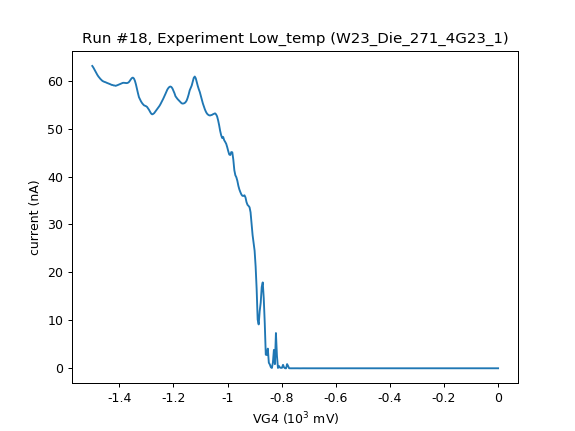

([<matplotlib.axes._subplots.AxesSubplot at 0x1f56548c408>], [None])

In [21]:
Vg1(-1500)
Vg2(-1500)
Vg3(-1500)
Vg4(0)
Vds(3)

exp_name='Low_temp'
sample_name='W23_Die_271_4G23_1'

exp = qc.new_experiment(exp_name, sample_name)
data_id=Sweeper.D1(Vg4,0,-1500,401,0.03,'Sweep_G1_LT_Vd_3mv',current)
plot_by_id(data_id)

<IPython.core.display.Javascript object>


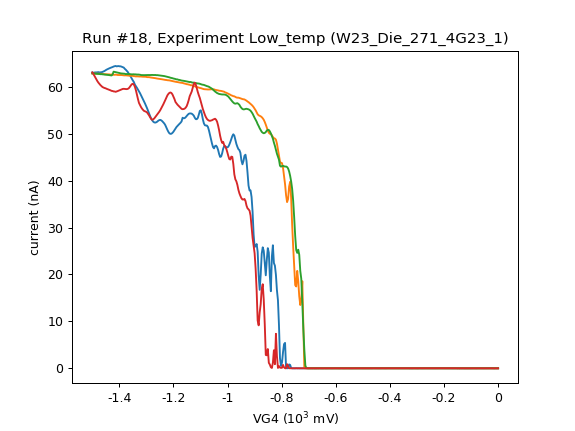

In [22]:
ax = multiplot_by_id([15,16,17,18])

## Reflecto maps

You first have to record a big map of your sensor, where triple points can be roughly evaluated

Starting experimental run with id: 92


<IPython.core.display.Javascript object>


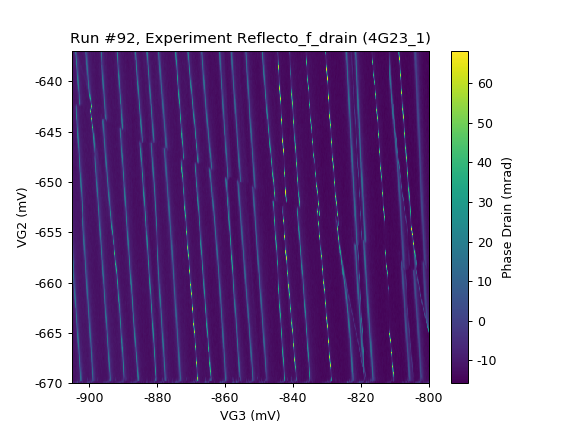

([<matplotlib.axes._subplots.AxesSubplot at 0x15852c17a48>],
 [<matplotlib.colorbar.Colorbar at 0x157657db408>])

In [210]:
Vg1(-1200)
Vg2(-643)
Vg2_fine(0)
Vg3_fine(0)
Vg3(-950)
Vg4(-1500)

awg.stop()
Singen.off()
# data_id=Sweeper.D2Timer(Vg3,-950,-900,251,0.01,Vg2,-642,-634,101,0.01,'Sweep_G3_G2',ph_d)

# data_id=Sweeper.D2Timer(Vg3,-905,-880,51,0.01,Vg2,-650,-640,51,0.01,'Sweep_G3_G2',ph_d)
data_id=Sweeper.D2Timer(Vg3,-905,-800,601,0.01,Vg2,-670,-637,401,0.01,'Sweep_G3_G2',ph_d)

plot_by_id(data_id)

In [683]:
# VG3 = [-904.5,-900.7,-897.3,-892.5,-887.3,-882,-878.7,-874.1,-869.6]
# VG2 = [-641,-641.5,642.5,-643.2,-644.2,-645.1,-645.3,-646.2,-647]


# Explore all the triple points

## Find working point and try Elzouzou

Give the coordinates of the triple points to study:

In [1]:
VG3 = [-902.7, -899.2, -895.2, -890, -884, -880.7, -877]
VG2 = [-642.3, -642.7, -643.7, -644.7, -646, -646, -646.6]

Then launch the script that will eventually (if each step is chosen as "True", but can be avoided by putting "false"):
- Replace on the triple point by doing a 2D scan,
- Replace more accuratley by sweeping the fine gates
- Study the tunnel rates for each triple point
- Record the "Bubbles" in the IQ plane for both states of the charge sensor
- Try Elzermann's readout on the triple point

In [1750]:
awg.stop()
plt.ioff()
compteur = 0
Singen.off()


Scan2d = True
Fine_Pos = True
time_traces = True
bubbles = True
elzouzou = True 

for i,j in zip((VG3),(VG2)) :

    if Scan2d == True:
        Vg2(j)
        Vg2_fine(0)
        Vg3_fine(0)
        Vg3(i)
        tc=10e-3
        ziUhf.daq.setDouble('/'+uhfRef+'/demods/6/timeconstant',tc)
        ziUhf.daq.setDouble('/'+uhfRef+'/demods/6/rate',1/tc) 
        ziUhf.daq.setDouble('/'+uhfRef+'/demods/6/order',3) 
        phasezero_ph7()

        data_id=Sweeper.D2Timer(Vg3,i-2.5,i+1,71,tc,Vg2,j-2,j+2,71,tc,'Sweep_G3_G2',ph_d)

        G2f=str(round(j,3))
        G3f= str(round(i,3))

    # Enregistrement du scan précédent sous forme 
        save_by_id(data_id,str(round(j,3)),str(round(i,3)))
        Field = z_magnet.field()
        pathh= f'..\exploration\g2=%s_g3=%s'%(str(round(j,3)),str(round(i,3)))

        Vgw2,Vgw3,a,b=find_working_point_by_id_inv(data_id,str(round(j,3)),str(round(i,3)))

# On se positionne sur le point de fonctionnement pour ne plus travailler qu'avec les grilles fines !   
    if Fine_Pos == True:
        Vg2(Vgw2)
        Vg3(Vgw3)

    # On affine le positionnement par un petit scan le long de epsilon:
        phase=np.array([])
        epsilon=np.array([])
        start=-1
        stop=1

        Vg2_fine(start)
        Vg3_fine(a*start)
        sleep(1)

        for i in np.arange(start,stop,5e-3) :
            Vg2_fine(i)
            Vg3_fine(a*i)
            sleep(0.05)
            phase=np.append(phase,ph_d())
            epsilon=np.append(epsilon,i)

        new_point,Threshold2 = precise_working_point(epsilon, phase,pathh) 
        Threshold2=Threshold2/1000

        Vgw2 = Vgw2 + new_point
        Vgw3 = Vgw3 + a*new_point  

    # # Et enfin on se replace:
        Vg2(Vgw2)
        Vg3(Vgw3)
    
# Sous code permettant d'obtenir les IQ bubbles dans le signal et en dehors du signal pour calculer a la fois le SNR et
# s'assurer qu'il n'y a pas un système a deux niveau qui traine dans le coin. 
    if bubbles == True:    
        #On regarde sur le signal lié à la transition 3->4 resonnante à une profondeur de n(mV) par rapport au cut 
        profondeur=1
        Vg2_fine(profondeur)
        Vg3_fine(a*profondeur)   

        tc=1e-6
        totaltime=0.5
        demod=7

        path2 = pathh + f'\IQ_on_signal'
        blopIQ(DAM7,tc,totaltime,demod,path2,str(round(j,3)),str(round(i,3)),title='IQ_On_Signal')

        #On regarde en epsilon=0 ! 
        profondeur=0
        Vg2_fine(profondeur)
        Vg3_fine(a*profondeur)   

        path2 = pathh + f'\IQ_epsilon=0'
        blopIQ(DAM7,tc,totaltime,demod,path2,str(round(j,3)),str(round(i,3)),title='IQ_Epsilon=0')

        #On regarde en dehors de tout signal ! 
        profondeur=-1
        Vg2_fine(profondeur)
        Vg3_fine(a*profondeur)   

        path2 = pathh + f'\IQ_out_of_signal'
        blopIQ(DAM7,tc,totaltime,demod,path2,str(round(j,3)),str(round(i,3)),title='IQ_Out_Of_Signal')

        #Trace la double bubble pour voir les superpositions, le SNR etc...
        path_dbb=[pathh + f'\IQ_on_signal.txt',pathh + f'\IQ_out_of_signal.txt']
        draw_multiple_bbl(path_dbb,pathh,str(round(j,3)),str(round(i,3)))
    
    if time_traces == True:
        #Enregistre les times traces dans un sous dossier time_traces qui seront a post traité dans la partie suivante     
        path3 = pathh + f'/time_traces'
        #pas de 2microVolt donc haute résolution 
        nb_elements=200
        path_ex=register_time_trace(DAM7,-0.2,0.2,nb_elements,1e-5,3,7,path3,a)
    
     #Post traitement des gammas rates et de la probabilité d'occupation dans le dot 
    
#     analyse_time_traces(pathh,Threshold2,str(round(j,3)),str(round(i,3)))
      
    # On tente le Elzouzou ici
    Vg2(Vgw2)
    Vg3(Vgw3) 
    Vg2_fine(0)
    Vg3_fine(0) 
    
    if elzouzou==True :
        tc_zouzou=1e-6

        ziUhf.daq.setDouble('/'+uhfRef+'/demods/6/timeconstant',tc_zouzou) 
        ziUhf.daq.setDouble('/'+uhfRef+'/demods/6/rate',1/tc_zouzou) 
        ziUhf.daq.setDouble('/'+uhfRef+'/demods/6/order',1) 
    #     Elzouzou(pathh,G2f,G3f,100, 30e-6, 200e-6, 100e-6)
        Elzouzou_fast(pathh,G2f,G3f,400, 30e-6, 200e-6, 100e-6)

#Définition de la séquence Init
print('Done')

Starting experimental run with id: 176



Dossier existant
Dossier existant
Dossier existant
Dossier existant
Done
